#Exec

In [ ]:
PLOT_SOLUTION_SPACE = False
PLOT_3D             = False
PLOT_POSITIONS      = False
ANIMATED_POSITIONS  = False
interval_plot       = 200

SAVE_POPULATION_HISTORY = True
SAVE_SOLUTION_SPACE     = True
SAVE_ENCODER            = True
SAVE_DECODER            = True

# Ontem anoite foi até o 15
for e in range(1,21):
  for r in range(1, 21):
    for i in range(1, 5):
      #FJSP(i, 1, r, 3, 30, 2.3,1,e)
      #FJSP(i, 1, r, 3, 30, 2.3,2,e)
      #FJSP(i, 1, r, 5, 30, 2.5,1,e)
      FJSP(i, 1, r, 5, 30, 2.5,2,e)
      #FJSP(i, 1, r, 6, 30, 2.645,1,e)
      #FJSP(i, 1, r, 6, 30, 2.645,2,e)
    #
  #
#

# FJSP

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import copy

from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import animation
from IPython.display import HTML

""" Classe para formulação do problema de FJSP """
class FJSP():
  """ Inicia o ambiente para os testes das diversas soluções """
  def __init__(self, id, problem, rod, cof, popz, cofpop, aprout, exec):
    self.id = id
    self.problem = problem
    self.process_times = []
    self.quant_operations_per_jobs = []

    self.quant_of_jobs = 0
    self.quant_of_operations = []
    self.quant_of_machines = []

    self.solution_space_size = 0
    self.solution_space_array_dimension = 0
    self.solution_space = None

    self.encode = None
    self.decode = None

    self.coeficente_populacional = cofpop
    self.population_size         = popz

    self.population = []
    self.g_best = None
    self.g_best_fitness = None

    self.path_to_load_space = f"drive/MyDrive/PSO_execs/Kacem/exec{rod}/problem{self.id}/cof{cof}"
    self.path_to_load_popul = f"drive/MyDrive/PSO_execs/Kacem/exec{rod}/problem{self.id}/cof{cof}"
    self.path_to_save = f"drive/MyDrive/PSO_execs/Kacem/exec{rod}/problem{self.id}/cof{cof}"

    self.start_environment()
    self.execute_direct_solution(aprout, exec)
  #

  """ Inicia o ambiente para os testes das diversas soluções """
  def start_environment(self):
    """ Pega o arquivo com o problema """
    if self.problem == 1:
      file_path = f"./Kacem{self.id}.fjs"
    elif self.problem == 2:
      file_path = f"./BrandimarteMk{self.id}.fjs"
    #

    input = Input(file_path)
    input_matrix_tuple = input.getMatrix()

    """ process_times: Matriz com os tempos de processamentos """
    self.process_times = input_matrix_tuple[0]

    """ quant_operations_per_jobs: Lista com o número de operações de cada job """
    self.quant_operations_per_jobs = input_matrix_tuple[1]

    """ Gerar população inicial """
    self.quant_of_jobs          = len(self.quant_operations_per_jobs)
    self.quant_of_operations    = self.process_times.shape[0]
    self.quant_of_machines      = self.process_times.shape[1]

    """ Calcula o tamanho do espaço de soluçoes """
    quantion_of_solutions = np.round(self.population_size ** self.coeficente_populacional)
    """ Faz um round da raiz para pegar a raiz quadrada perfeita mais proxima """
    self.solution_space_array_dimension = int(np.round(np.sqrt(quantion_of_solutions)))
    self.solution_space_size = self.solution_space_array_dimension ** 2
    #print(f"Tamanho do espaço de soluções: {self.solution_space_size}")

    """ Inicia as classes de encode e decode para serem usados no problema """
    self.encode = Encode(self.solution_space_size,       self.process_times, self.quant_operations_per_jobs)
    self.decode = Decode(self.quant_operations_per_jobs, self.process_times)

    """ Inicia o espaço de soluções """
    #self.solution_space = self.encode.initialize_solution_space()
    self.solution_space = np.load(f"{self.path_to_load_space}/solution_space.npy")

    self.population = np.load(f"{self.path_to_load_popul}/population.npy", allow_pickle=True)

    self.g_best = np.load(f"{self.path_to_load_popul}/gbest_inical.npy")
    self.g_best_fitness = self.decode.decode(self.solution_space[self.g_best[0],self.g_best[1]])

    for particle in self.population:
      if (self.g_best_fitness is None) or (particle.fitness < self.g_best_fitness):
        self.g_best_fitness = particle.fitness
        self.g_best         = particle.position
      #
    #

    #self.execute_direct_solution()
    pass
  #

  def execute_direct_solution(self, aprout, exec):
    positions_history = []
    g_best_count = 0
    g_best_changes = 0

    solutioned = False
    while not solutioned:
      g_best_changed = False
      positions = [p.position for p in self.population]
      positions.append(self.g_best)
      positions_history.append(positions)
      for particula in self.population:
        particula.update_position(self.g_best, g_best_count, aprout)
        particula.evaluate_value(self.solution_space, self.decode)
        if particula.fitness < self.g_best_fitness:
          self.g_best = particula.position
          self.g_best_fitness = particula.fitness
          g_best_changed = True
        #
      #
      if g_best_changed:
        g_best_count = 0
        g_best_changes += 1
      else:
        g_best_count += 1
      #

      if g_best_count > 50:
        solutioned = True
      pass
    #

    if SAVE_POPULATION_HISTORY:
      self.save_population_history(positions_history, aprout, exec)
    #

    solution = self.solution_space[self.g_best[0], self.g_best[1]]
    self.save_solution(self.g_best, self.g_best_fitness, solution, aprout, exec)
  #

  def save_population_history(self, population_history,aprout, exec):
    if not os.path.exists(self.path_to_save):
      os.makedirs(self.path_to_save)
    np.save(f'{self.path_to_save}/particles_positions_history{aprout}_exec{exec}.npy', population_history)
    #np.save(f'executions_data/particles_positions_history{aprout}_exec{exec}.npy', population_history)
  #

  def save_solution(self, gbest, fitness, solution, aprout, exec):
    if not os.path.exists(self.path_to_save):
      os.makedirs(self.path_to_save)
    #

    np.save(f'{self.path_to_save}/gbest_aprout{aprout}_exec{exec}.npy', gbest)
    np.save(f'{self.path_to_save}/fitness_aprout{aprout}_exec{exec}.npy', fitness)
    np.save(f'{self.path_to_save}/solution_aprout{aprout}_exec{exec}.npy', solution)
    #np.save(f'executions_data/gbest_aprout{aprout}_exec{exec}.npy', gbest)
    #np.save(f'executions_data/fitness_aprout{aprout}_exec{exec}.npy', fitness)
    #np.save(f'executions_data/solution_aprout{aprout}_exec{exec}.npy', solution)
  #
#

# Encode

In [ ]:
#import random
import numpy as np

""" Class that represent the enconding of Solution Space """
class Encode:

    """ Init the class that represent the enconding of problem """
    def __init__(self, solution_space_size, process_times, quant_operations_per_jobs):
        self.solution_space_size        = solution_space_size
        self.process_times              = process_times
        self.quant_operations_per_jobs  = quant_operations_per_jobs

        self.quant_of_jobs = len(quant_operations_per_jobs)

        self.quant_of_machines = process_times.shape[1]
        self.half_of_scheduling = process_times.shape[0]

        self.solution_size = self.half_of_scheduling * 2
    #

    """ Return a list with all operations, represented by number of his job """
    def ordened_operations(self):
        operations = []
        for jb, op in enumerate(self.quant_operations_per_jobs):
            for _ in range(op):
                operations.append(jb+1)
        #

        return operations
    #

    """ Method to create a random solution space """
    def generate_solution_space(self):
        """ Inicializa uma lista vazia para o agendamento das maquinas e das operações """
        """ Importante tomar cuidado com inicializar como 0 ou empty por isso influencia no resultado final por lixo de memoria """
        range_of_machines = range(1, self.quant_of_machines+1)
        matrix_dimensions = (self.solution_space_size, self.half_of_scheduling)
        machines_scheduling   = np.random.choice(range_of_machines, matrix_dimensions)
        operations_scheduling = np.random.choice(range_of_machines, matrix_dimensions)

        """ Faz uma shallow copy da lista de operações """
        operations = np.copy(self.ordened_operations())

        """ Percore cada solução do espaço de soluções """
        for solution_i in range(self.solution_space_size):

            """ Randomiza a lista de operações """
            np.random.shuffle(operations)

            """ Faz uma shallow copy das operações para esse agendamento """
            operations_scheduling[solution_i] = np.copy(operations)

            """ Inicia as listas de jobs e de maquinas, ambas vazias """
            jobs_list       = np.arange(self.quant_of_jobs)
            machines_list   = np.zeros(self.quant_of_machines, dtype=int)

            """ Itera uma vez para cada job """
            for _ in range(self.quant_of_jobs):

                """ Escolhe um Job aleatoriamente """
                job_num = np.random.choice(jobs_list)

                """ Indice de inicio e fim nas operações desse job """
                index_of_start_operation = sum(self.quant_operations_per_jobs[:job_num])
                index_of_end_operation = index_of_start_operation + self.quant_operations_per_jobs[job_num]

                """ Percorre todas as operações desse job """
                for operation in range(index_of_start_operation, index_of_end_operation):

                    """ Lista temporaria de cargas de trabalho """
                    load = []
                    for (process_time, machine_load) in zip(self.process_times[operation], machines_list):
                        if process_time != -1:
                            load.append(process_time + machine_load)
                    #

                    """ Lista temporaria de indice de carga de trabalho """
                    load_indexes = []
                    for (index, process_time) in enumerate(self.process_times[operation]):
                        if process_time != -1:
                            load_indexes.append(index)
                    #

                    """ Indices da maquina e da carga com menor carga de trabalho """
                    less_busy_machine_index = np.argmin(load)
                    less_busy_load_index = load_indexes[less_busy_machine_index]

                    """ Grava na lista de agendamento de maquinas a maquina com menor carga de trabalho """
                    machines_scheduling[solution_i][operation] = less_busy_machine_index+1

                    """ Grava a carga na lista de maquinas """
                    machines_list[less_busy_load_index] = load[less_busy_machine_index]
                #

                """ Exclui esse job excolhido da lista de jobs """
                np.delete(jobs_list, job_num)
            #

            #print()
        #

        solution_space = np.hstack((machines_scheduling, operations_scheduling))
        return solution_space
    #

    """ Method that create and return a random solution space """
    def initialize_solution_space(self):
        random_solution_space = self.generate_solution_space()

        dimension_size = int(np.sqrt(self.solution_space_size))
        solution_space_shape = (dimension_size, dimension_size, self.solution_size)

        solution_space = random_solution_space.reshape(solution_space_shape)

        return solution_space
    #

# Decode

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

class Decode:

    def __init__(self, quant_operations_per_jobs, process_times):
        self.quant_operations_per_jobs = quant_operations_per_jobs
        self.process_times = process_times
        self.quant_of_jobs = len(quant_operations_per_jobs)
        self.quant_of_machines = process_times.shape[1]
        self.half_of_scheduling = process_times.shape[0]
        self.max_of_operations = np.max(quant_operations_per_jobs)

    #https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.barh.html
    def draw_gatt(self, start_time, end_time, fig):
        colors = {0:'red', 1:'blue', 2:'yellow', 3:'orange', 4:'green'}

        #ax = fig.add_subplot(1, 2, 2)
        ax = plt.figure()

        # i = Machine_index ; j = Operation_index
        for i in range( self.quant_of_machines ): # Vai de linha em linha do plot (começando do 0)
            for j in range( self.half_of_scheduling ):
                current_start_time      = start_time[i][j]
                current_end_time        = end_time[i][j]
                current_diference_time  = current_end_time - current_start_time
                #if current_diference_time > 0:
                if end_time[i][j] != 0 and end_time[i][j] - start_time[i][j] != 0:
                    operation = self.find_machine_of_a_operation(j)
                    bar_width = current_diference_time
                    bar_left = current_start_time
                    bar_color = colors[operation[0] - 1]
                    #bar_str = operation[0] # Somente o numero do Job
                    bar_str = operation     # Numero do Job e da Operação

                    ax.barh(y=i, width=bar_width, height=0.5, left=bar_left, color=bar_color, edgecolor='black')
                    ax.text(x=bar_left + 0.1, y=i, s=bar_str, fontsize=8)

        #ax.yticks(np.arange(i + 1), np.arange(1, i + 2))

        #self.save_plot_image(plt)
    #

    # Função para salvar a image de um plot em um arquivo
    def save_plot_image(self, plt):
        path = './BestFitness/BrandimarteMk1/'
        if not os.path.exists(path):
            os.makedirs(path)

        img_path = path + 'best_fitness.png'
        if os.path.exists(img_path):
            os.remove(img_path)

        plt.savefig(img_path)

    # Encontrar o indice de uma operação em uma máquina
    def find_one_operation_in_a_machine(self, i, j):
        if i == 1:
            op_index = j - 1
        else:
            op_index = sum(self.quant_operations_per_jobs[:i - 1]) + j - 1

        return op_index

    # Dado o índice de uma operação, descobre qual em qual maquina está
    """ retorna uma tupla (maquina, operação) """
    def find_machine_of_a_operation(self, operation_index):
        job_op_list = [
            (i + 1, j + 1) for i in range( self.quant_of_jobs ) for j in range(self.quant_operations_per_jobs[i])
        ]
        job_op = job_op_list[operation_index]
        return job_op
    #

    # Decode a Scheduling and return the Fitness
    def decode(self, scheduling, plot_scheduling=False, fig=None):
        machines_matrix = np.zeros((self.quant_of_jobs, self.max_of_operations), dtype=int)
        times_matrix    = np.zeros((self.quant_of_jobs, self.max_of_operations), dtype=int)

        machines_scheduling   = scheduling[:self.half_of_scheduling]
        operations_scheduling = scheduling[self.half_of_scheduling:]

        operation_index = 0
        for i in range( self.quant_of_jobs ):
            for j in range( self.quant_operations_per_jobs[i] ):
                count = 0
                process_time = self.process_times[operation_index]

                for index in range( len(process_time) ):
                    if process_time[index] != -1:
                        count+=1

                    if count == machines_scheduling[operation_index]:
                        machines_matrix[i][j] = index+1
                        times_matrix[i][j]  = process_time[index]
                        break

                operation_index+=1

        #print(machines_matrix)
        #print(times_matrix)

        start_time = np.zeros(
            (self.quant_of_machines, self.half_of_scheduling),
            dtype=int
        )

        end_time = np.zeros(
            (self.quant_of_machines, self.half_of_scheduling),
            dtype=int
        )

        op_count_dict = {}
        machine_operations = np.zeros(self.quant_of_machines, dtype=int)

        for os in operations_scheduling:
            if os in op_count_dict:
                op_count_dict[os] += 1
            else:
                op_count_dict[os] = 1
            #

            operation_count = op_count_dict[os]
            operation_index = self.find_one_operation_in_a_machine(os, operation_count)

            machine_number     = machines_matrix[os-1][operation_count-1]
            pro_time           = times_matrix [os-1][operation_count-1]

            machine_operation  = machine_operations[machine_number-1]
            current_start_time = start_time[machine_number-1][operation_index]
            current_end_time   = end_time  [machine_number-1][operation_index]

            previous_operation_index = self.find_one_operation_in_a_machine(os, operation_count - 1)
            previous_machine_number = machines_matrix[os-1][operation_count-2]

            if machine_operation == 0 and operation_count == 1 :
                current_start_time = 0
                current_end_time   = pro_time
            #

            elif machine_operation == 0 and operation_count > 1 :
                prev_m_num          = machines_matrix[os-1][operation_count-2]
                prev_end_time       = end_time[prev_m_num-1][previous_operation_index]
                current_start_time  = prev_end_time
                current_end_time    = prev_end_time + pro_time
            #

            elif machine_operation > 0:
                flag=0
                prev_end_time = 0

                if operation_count == 1 :
                    free_start = 0
                else:
                    prev_end_time = end_time[previous_machine_number-1][previous_operation_index]
                    free_start = prev_end_time
                #

                order_start_time = np.sort(start_time[machine_number-1][end_time[machine_number-1] > 0])
                order_end_time   = np.sort(end_time  [machine_number-1][end_time[machine_number-1] > 0])

                for index in range(len(order_start_time)):
                    if order_start_time[index] - free_start >= pro_time:
                        current_start_time = free_start
                        current_end_time   = free_start + pro_time
                        flag = 1
                        break
                    #

                    if order_end_time[index] - free_start >= 0:
                        free_start = order_end_time[index]
                    #
                #

                if flag == 0:
                    free_start = max(np.max(end_time[machine_number-1]), prev_end_time)
                    current_start_time = free_start
                    current_end_time   = free_start + pro_time
                #
            #

            machine_operation += 1

            machine_operations[machine_number - 1]          = machine_operation
            start_time[machine_number - 1][operation_index] = current_start_time
            end_time  [machine_number - 1][operation_index] = current_end_time
        #

        #print(scheduling)
        if plot_scheduling:
            self.draw_gatt(start_time, end_time, fig)
        #

        fitness = np.max(end_time)

        return fitness
    #


# Particula

In [ ]:
#import Decode
import numpy as np
import random

"""
Classe que representa e gerencia a entidade de uma particula
"""
class Particle:

    """
    Inicia a entidade da particula
    Caso generate_random seja True, chama o preenchedor de valores aleatorios
    """
    def __init__(self, solution_space_size, solution_space, decoder, hyper_params, generate_random = False):
        self.position = None
        self.velocity = None
        self.velocity_limit = hyper_params["velocity_limit"]
        #self.direction = None
        self.p_best = None
        self.p_best_fitness = None
        self.value = None
        self.fitness = None
        self.last_position = None
        self.solution_space_size = solution_space_size
        self.solution_space_limit = solution_space.shape[0]

        if generate_random:
            self.fill_with_random_values(self.solution_space_limit, solution_space, decoder)
    #

    """
    Preenche a particula com valores aleatorios
    """
    def fill_with_random_values(self, solution_space_limit, solution_space, decoder):
        """ ... """

        """ Começa em 1 e deduz 1 do limite """
        """ para ele não ir parar nas bordas e não conseguir movimentar """
        random_position = np.array(random.sample(range(1, solution_space_limit - 1), 2))
        """ Converte de array para list para manter o padrão de datatype da solução """
        self.position = [int(random_position[0]), int(random_position[1])]

        """ Sorteia aleatoriamente uma possição anterior """
        """ Se for '+1' vai criar um vetor de movimento para a frente """
        """ Se for '-1' vai criar um vetor de movimento para a traz """
        self.last_position = random_position + 1 if random.choice([True, False]) else random_position - 1

        #self.velocity = random.uniform(0, self.velocity_limit)
        self.velocity = 1

        self.evaluate_value(solution_space, decoder)
        self.p_best = self.position
    #

    """
    Atualiza a posição, velocidade e inercia da particula.
    Chamado pela iteração do PSO
    """
    def update_position(self, g_best, g_best_count, aprout):
        x_position = self.position[0]
        y_position = self.position[1]
        velocity = self.velocity

        #print("Stop!")

        p_best_vector   = np.array([self.p_best[0],  self.p_best[1]  ])
        g_best_vector   = np.array([g_best[0],       g_best[1]       ])

        #median_best_vector = ((p_best_vector + g_best_vector)/2)

        innitial_position   = np.array([x_position, y_position])
        inertia_vector      = (innitial_position * velocity)

        """ Deduz a possição inicial para ele setar o calculo com base no zero do vetor """
        """ E então soma a innercia e obtem a posição final """
        #final_vector = (median_best_vector) + innitial_position
        median_best_vector = ((p_best_vector + g_best_vector) / 2)
        final_vector =  ((median_best_vector + innitial_position)) / 2
        if aprout == 1:
          final_vector = final_vector + 0.9*random.random() # Fator aleatorio
        else:
          if g_best_count > 5:
            final_vector = final_vector + 0.9*(inertia_vector*random.random()) # Inercia com importancia aleatoria
          else:
            final_vector = final_vector + 0.9*random.random() # Fator aleatorio
        #final_vector = final_vector + 0.9                   # Movimento fixo
        #final_vector = final_vector + 0.9*(inertia_vector*random.random()) # Inercia com importancia aleatoria
        
        #final_vector = (final_vector + innitial_position) / 2
        #final_vector = (final_vector + innitial_position) / 2
        #final_vector = (final_vector + innitial_position) / 2

        #if (final_vector[0] == innitial_position[0]) and (final_vector[1] == innitial_position[1]):
            #final_vector = g_best_vector

        """
        print(f"Posição => {innitial_position}")
        print(f"gBest => {g_best_vector}")
        print(f"pBest => {p_best_vector}")
        print(f"Movimento => {final_vector}")
        print("---------------------")
        """

        #print("Stop!")

        if final_vector is not None:
            new_x_position = final_vector[0]
            new_y_position = final_vector[1]

            """ Validações para caso seja numero negativo (tenha ido para fora do mapa) """
            if new_x_position < 0:
                new_x_position = 0
            #
            if new_y_position < 0:
                new_y_position = 0
            #

            """ Validação para caso seja maior que o limite matrix (tenha ido para fora do mapa) """
            if new_x_position >= self.solution_space_limit:
                new_x_position = self.solution_space_limit - 1
            #
            if new_y_position >= self.solution_space_limit:
                new_y_position = self.solution_space_limit - 1
            #

            self.position = [int(new_x_position), int(new_y_position)]

        pass
    #

    """
    Calcula e atualiza os valores de posição, fitness e p_best da particula 
    """
    def evaluate_value(self, solution_space, decoder):
        self.value = solution_space[self.position[0], self.position[1]]
        fitness = decoder.decode(self.value)
        self.fitness = fitness

        if (self.p_best_fitness is None) or (fitness < self.p_best_fitness):
            self.p_best_fitness = fitness
            self.p_best = self.position
    #


# Read Data

In [ ]:
import numpy as np

class Input:
    
    def __init__(self, inputFile: str):
        self.machines = []
        self.operations = []
        self.__proNum = []
        self.__lines = None
        self.__input = inputFile
        self.Mac_Num=0
        self.Job_Num=0
        self.quant_operations_per_jobs=[]
    #

    def getMatrix(self):
        self.__readExample()
        self.__initMatrix()
        for i in range(len(self.__lines)-1):
            lo = 0
            hi = 0
            for j in range(self.__proNum[i]):
                head = int(self.__lines[i][lo])
                hi = lo + 2 * head + 1

                lo += 1
                while lo < hi:
                    self.machines[i][j].append(int(self.__lines[i][lo]))
                    self.operations[i][j].append(int(self.__lines[i][lo + 1]))
                    lo += 2


        p_table=self.DataConversion()
        return (p_table, self.quant_operations_per_jobs)
    #

    def __readExample(self):
        with open(self.__input) as fileObject:
            self.__lines = fileObject.readlines()

        self.__lines[0] = self.__lines[0].lstrip().rstrip().split("\t")

        self.Job_Num=int(self.__lines[0][0])
        self.Mac_Num=int(self.__lines[0][1])

        # Ajuste de dados
        del self.__lines[0]
        # Aqui para ser um a menos

        for i in range(len(self.__lines)-1):

            self.__lines[i] = self.__lines[i].lstrip().rstrip().split(" ")
            operation=int(self.__lines[i].pop(0))
            self.quant_operations_per_jobs.append(operation)
            self.__proNum.append(operation)
            while "" in self.__lines[i]:
                self.__lines[i].remove("")
    #

    def __initMatrix(self):
        for i in range(len(self.__proNum)):
            self.machines.append([])
            self.operations.append([])
            for _ in range(self.__proNum[i]):
                self.machines[i].append([])
                self.operations[i].append([])
    #

    def DataConversion(self):
        total_of_operations = np.sum(self.quant_operations_per_jobs)
        
        # Matriz de tempo de processamento process_times: número total de processos * m;
        # entre eles, o processamento não é possível e é representado por -1
        process_times = np.ones((total_of_operations,self.Mac_Num), dtype=int)*(-1)
        index = 0
        for (i1, i2) in zip(self.machines, self.operations):
            for (j1,j2) in zip(i1, i2):
                for (k1,k2) in zip(j1, j2):
                    process_times[index][k1-1]=k2
                index += 1

        return process_times
    #

#

#Test execs

In [ ]:
""""""
gchanges1 = []
fitness1 = []
for _ in range(0,50):
  myfjsp = FJSP(3, 1, 1, 3)
  res = myfjsp.execute_direct_solution(1)
  _gchanges = res[0]
  _fitness = res[1]
  gchanges1.append(_gchanges)
  fitness1.append(_fitness)
gc1 = np.array(gchanges1)
ft1 = np.array(fitness1)

gchanges2 = []
fitness2 = []
for _ in range(0,50):
  myfjsp = FJSP(3, 1, 1, 3)
  res = myfjsp.execute_direct_solution(2)
  _gchanges = res[0]
  _fitness = res[1]
  gchanges2.append(_gchanges)
  fitness2.append(_fitness)
gc2 = np.array(gchanges2)
ft2 = np.array(fitness2)


#plt.hist(gc1, bins=np.arange(0,gc1.max()+3))
#plt.show()
plt.hist(ft1, bins=np.arange(12,17))
plt.show()
#plt.hist(gc1, bins=np.arange(0,gc1.max()+3))
#plt.show()
plt.hist(ft2, bins=np.arange(12,17))

11


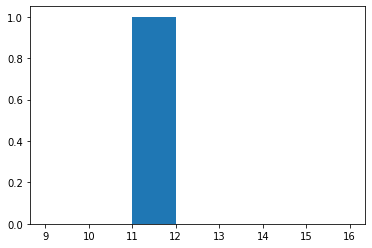

12


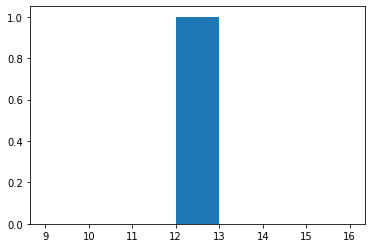

In [ ]:
ft = np.load("executions_data/fitness_aprout1_exec1.npy")
print(ft)
plt.hist(ft, bins=np.arange(9,17))
plt.show()
ft2 = np.load("executions_data/fitness_aprout2_exec1.npy")
print(ft2)
plt.hist(ft2, bins=np.arange(9,17))
plt.show()